In [1]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [qiskit]


In [3]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.4 MB/s eta 0:00:00


In [4]:
!pip install qiskit-ibm-runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [qiskit-ibm-runtime]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.


In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Statevector

In [6]:
backend = FakeSherbrooke()
noise_model = NoiseModel.from_backend(backend)
basis_gates = NoiseModel.basis_gates

ideal_sim = AerSimulator()
noisy_sim = AerSimulator(noise_model = noise_model)

In [7]:
#defining hamiltonian
H = SparsePauliOp.from_list([
    ("XX", 1.0),
    ("YY", 1.0),
    ("ZZ", 1.0)
])

In [8]:
#initaialising the circuit
qc = QuantumCircuit(2)
qc.x(0)                      # Prepare |10⟩

In [23]:
from qiskit.quantum_info import Pauli
# --- Observables ---
obs_labels = ["⟨X₀X₁⟩", "⟨Y₀Y₁⟩", "⟨Z₀Z₁⟩"]
observables = [Pauli("XX"), Pauli("YY"), Pauli("ZZ")]
obs_values = {label: [] for label in obs_labels}

# --- Dynamical correlation: ⟨Z₁(t) Z₀⟩ ---
dyn_corr = []

In [24]:
from qiskit.quantum_info import Statevector, DensityMatrix, Pauli, state_fidelity
from qiskit.synthesis import LieTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit, transpile

fidelities = []
times = np.linspace(0, 3, 13)

for t in times:
    # Evolution gate
    gate = PauliEvolutionGate(H, time=t, synthesis=LieTrotter())

    # Initial state
    psi_init = Statevector.from_instruction(qc)
    ideal_qc = qc.copy()
    ideal_qc.append(gate, [0, 1])
    psi_ideal = Statevector.from_instruction(ideal_qc)

    noisy_qc = qc.copy()
    noisy_qc.append(gate, [0, 1])
    noisy_qc.save_density_matrix()
    transp_noisy = transpile(noisy_qc, backend=noisy_sim)
    result = noisy_sim.run(transp_noisy).result()
    dm_data = result.data(0)['density_matrix']
    psi_noisy = DensityMatrix(dm_data)

    # Fidelity
    fidelity = state_fidelity(psi_ideal, psi_noisy)
    fidelities.append(fidelity)

    # Observables (ideal)
    for label, pauli in zip(obs_labels, observables):
        val = psi_ideal.expectation_value(pauli)
        obs_values[label].append(np.real(val))

    # Dynamical correlation ⟨Z1(t) Z0⟩
    psi_prime = psi_init.evolve(Pauli("Z") ^ Pauli("I"))  # Apply Z₀
    evo_circuit = QuantumCircuit(2)
    evo_circuit.append(gate, [0, 1])
    psi_prime_t = psi_prime.evolve(evo_circuit)
    c_val = psi_prime_t.expectation_value(Pauli("I") ^ Pauli("Z"))
    dyn_corr.append(np.real(c_val))


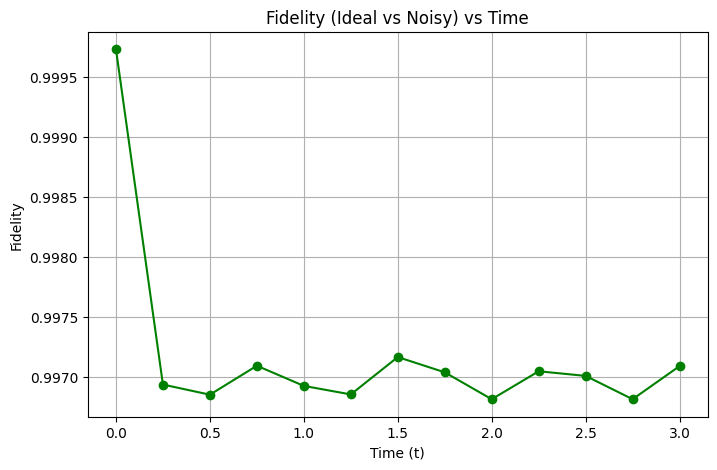

In [21]:
#fidelity vs time
if any(f is not None for f in fidelities):
    plt.figure(figsize=(8, 5))
    plt.plot(times, fidelities, label="Fidelity", marker='o', color='green')
    plt.xlabel("Time (t)")
    plt.ylabel("Fidelity")
    plt.title("Fidelity (Ideal vs Noisy) vs Time")
    plt.grid(True)
    plt.show()


/tmp/ipython-input-25-1685992625.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


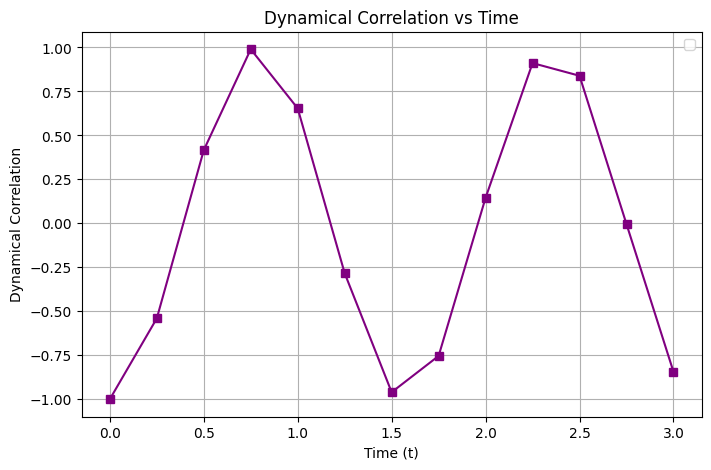

In [25]:
#corelation vs time
plt.figure(figsize=(8, 5))
plt.plot(times, dyn_corr, marker='s', color='purple')
plt.xlabel("Time (t)")
plt.ylabel("Dynamical Correlation")
plt.title("Dynamical Correlation vs Time")
plt.grid(True)
plt.legend()
plt.show()


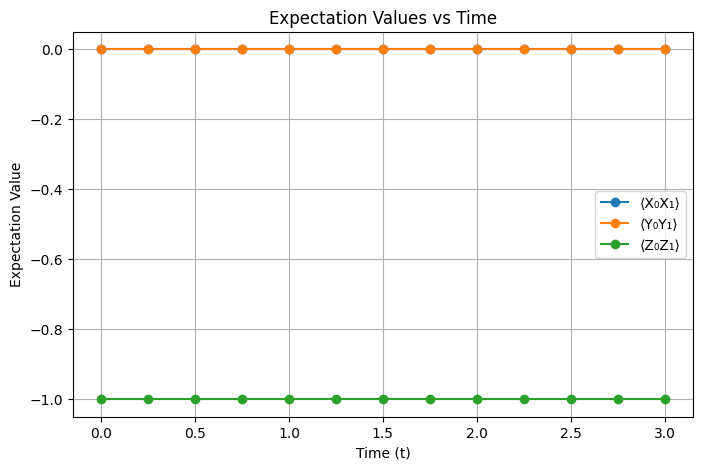

In [26]:
#expectation values vs time
plt.figure(figsize=(8, 5))
for label in obs_labels:
    plt.plot(times, obs_values[label], label=label, marker='o')
plt.xlabel("Time (t)")
plt.ylabel("Expectation Value")
plt.title("Expectation Values vs Time")
plt.legend()
plt.grid(True)
plt.show()
